## **Bài tập lớn: Phân tích biến động giá cổ phiếu Intel (INTC)**
### **Môn học: Lập trình xử lí dữ liệu với python**
**Sinh viên:**
- Nguyễn Văn Vũ - 24022493


#### **I. Thu thập và xử lí dữ liệu**
Tất cả các thư viện cần dùng:

In [41]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

Thu thập dữ liệu:

                       Date       Open       High        Low      Close  \
0 2023-06-01 00:00:00-04:00  31.164772  31.301977  30.400354  30.508156   
1 2023-06-02 00:00:00-04:00  30.772761  30.958966  30.214148  30.684559   
2 2023-06-05 00:00:00-04:00  30.684561  30.772763  29.234126  29.263527   
3 2023-06-06 00:00:00-04:00  29.175323  30.821764  29.106722  30.341551   
4 2023-06-07 00:00:00-04:00  30.410155  30.743363  30.312152  30.655161   

     Volume  Dividends  Stock Splits  
0  52667400        0.0           0.0  
1  36496200        0.0           0.0  
2  48244100        0.0           0.0  
3  42295300        0.0           0.0  
4  39098000        0.0           0.0  


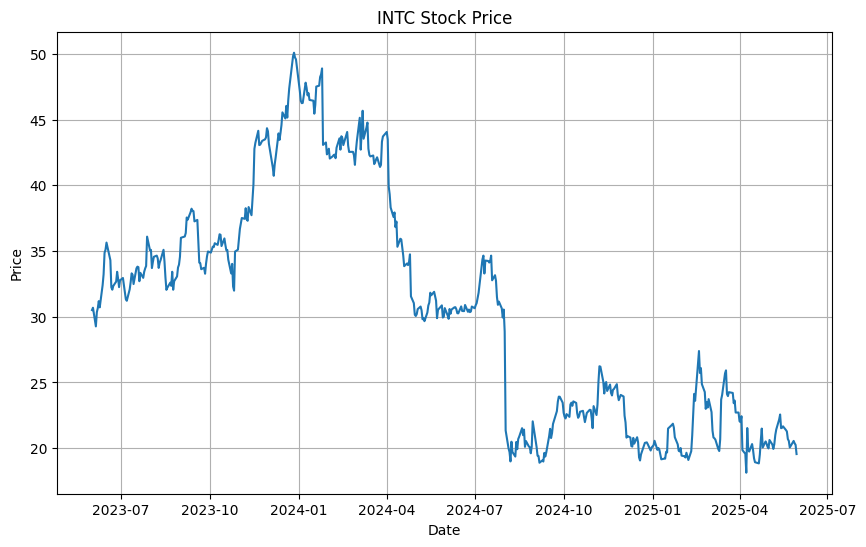

In [38]:
symbol = "INTC"
start = datetime(2023, 6, 1)
end = datetime(2025, 6, 1)
df = yf.Ticker(symbol).history(start=start, end=end).reset_index()
df.to_csv("data/data.csv", index=False)

print(df.head())
plt.figure(figsize=(10, 6)) 
sns.lineplot(data=df, x='Date', y='Close')
plt.title(f'{symbol} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()



Làm sạch và tiền xử lý dữ liệu:

In [ ]:
df = pd.read_csv("data/data.csv")

# Chuyển cột ngày tháng về định dạng datetime
df['Date'] = pd.to_datetime(df['Date'])

# Xóa dòng có giá trị bị thiếu (NaN)
df = df.dropna()

# Kiểm tra và loại bỏ bất thường (outliers)
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
z_scores = np.abs(stats.zscore(df[numeric_cols]))
df = df[(z_scores < 3).all(axis=1)] 

# Loại bỏ 'Dividends' và 'Stock Splits' vì không ảnh hưởng trực tiếp đến phân tích kỹ thuật giá ngắn và trung hạn
df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

df.to_csv("data/data_clean.csv", index=False)
df.head()


C:\Users\bossg\AppData\Local\Temp\ipykernel_9504\4170571114.py:4: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Open,High,Low,Close,Volume
0,2023-06-01 00:00:00-04:00,31.164772,31.301977,30.400354,30.508156,52667400
1,2023-06-02 00:00:00-04:00,30.772761,30.958966,30.214148,30.684559,36496200
2,2023-06-05 00:00:00-04:00,30.684561,30.772763,29.234126,29.263527,48244100
3,2023-06-06 00:00:00-04:00,29.175323,30.821764,29.106722,30.341551,42295300
4,2023-06-07 00:00:00-04:00,30.410155,30.743363,30.312152,30.655161,39098000


Tính toán chỉ số kỹ thuật cơ bản:
- *SMA_20*
- *SMA_50*
- *EMA_20*
- *RSI_14*
- *OBS*
- *ATR_14*

In [ ]:
df = pd.read_csv("data/data_clean.csv")

# SMA: Simple Moving Average 
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# EMA: Exponential Moving Average
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

# RSI: Relative Strength Index
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
df['RSI_14'] = compute_rsi(df['Close'])

# OBV: On-Balance Volume
df['OBV'] = 0
df.loc[0, 'OBV'] = df.loc[0, 'Volume']  
for i in range(1, len(df)):
    if df.loc[i, 'Close'] > df.loc[i-1, 'Close']:
        df.loc[i, 'OBV'] = df.loc[i-1, 'OBV'] + df.loc[i, 'Volume']
    elif df.loc[i, 'Close'] < df.loc[i-1, 'Close']:
        df.loc[i, 'OBV'] = df.loc[i-1, 'OBV'] - df.loc[i, 'Volume']
    else:
        df.loc[i, 'OBV'] = df.loc[i-1, 'OBV']

# ATR: Average True Range       
high_low = df['High'] - df['Low']
high_prev_close = abs(df['High'] - df['Close'].shift(1))
low_prev_close = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = pd.concat([high_low, high_prev_close, low_prev_close], axis=1).max(axis=1)
df['ATR_14'] = df['TR'].rolling(window=14).mean()
df.drop(columns=['TR'], inplace=True)

df.to_csv("data/data_clean.csv", index=False)
df[['Date', 'Close', 'SMA_20', 'SMA_50', 'EMA_20', 'RSI_14', 'OBV', 'ATR_14']].head(50)


,Date,Close,SMA_20,SMA_50,EMA_20,RSI_14,OBV,ATR_14
0,2023-06-01 00:00:00-04:00,30.508156,NaN,NaN,30.508156,NaN,52667400,NaN
1,2023-06-02 00:00:00-04:00,30.684559,NaN,NaN,30.524956,NaN,89163600,NaN
2,2023-06-05 00:00:00-04:00,29.263527,NaN,NaN,30.404820,NaN,40919500,NaN
3,2023-06-06 00:00:00-04:00,30.341551,NaN,NaN,30.398794,NaN,83214800,NaN
4,2023-06-07 00:00:00-04:00,30.655161,NaN,NaN,30.423210,NaN,122312800,NaN
5,2023-06-08 00:00:00-04:00,31.184374,NaN,NaN,30.495702,NaN,157511800,NaN
6,2023-06-09 00:00:00-04:00,30.713963,NaN,NaN,30.516489,NaN,117293800,NaN
7,2023-06-12 00:00:00-04:00,32.409405,NaN,NaN,30.696766,NaN,177175400,NaN
8,2023-06-13 00:00:00-04:00,33.232624,NaN,NaN,30.938277,NaN,229165400,NaN
9,2023-06-14 00:00:00-04:00,34.869263,NaN,NaN,31.312656,NaN,303569700,NaN
